<a href="https://colab.research.google.com/github/xslittlemaggie/Machine-Learning-Projects/blob/master/User_purchase_prediction_LR_RF_XGBoosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center> The user purchase probability prediction </center></h1>

<h1>Table of contents</h1>

<div class="alert alert-block alert-info" style="margin-top: 24px">
    <ol>
        <li><a href="#purpose of the study">Project Understanding</a></li>
        <li><a href="#Load dataset cleaned from SQL">Load dataset cleaned from SQL</a></li>
        <li><a href="#Get familar with the data">Get familar with the data</a></li>
        <li><a href="#Training, validation, testing datasets split">Training, validation, testing datasets split</a></li>
        <li><a href="#Data normalization">Data normalization</a></li>
        <li><a href="#Model  building">Model  building</a></li>
        <li><a href="#Comparisons of the three models: Logistic Regression, Random Forest, xgboost">Comparisons of the 3 models: LR, RF, XGBoost</a></li>
        <li><a href="#Test dataset prediction from the best performance model: Random Forest">Test dataset prediction from the best model among the 3: Random Forest</a></li>
    </ol>
</div>
<br>
<hr>

# 0: Import libraries

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# 1. Project Understanding

**1. The Purpose：**

The purpose of this project is to predict the user purchase probability through the user purchasing behavirous, such as dates, view frequencys, activity types (e.g. EmailOpen, EmailClickthrough, etc).

**2. The Data:**

The original dataset is a raw log. It has 3 columns, 500000 rows that record user activity over time:
- user_id: A hash that uniquely identifies the user

- activity_date: The date of the activity

- activity_type: The type of activity

  - EmailOpen

  - EmailClickthrough

  - WebVisits

  - PageViews

  - FormSubmit

  - CustomerSupport

  - Purchase

After data cleaning and feature extraction from SQL, the final data has 34850 (unique users) records, 18 features (IV) and 1 target variable, **is_purchase** 
- 0: No
- 1: Yes

**3. The models:**

Classification models are used to  predicts which user_id are most likely to make a purchase in the future. 

(1). Logistic Regression: Easy understanding

(2). Random Forest: One of the bagging ensembling method. Complex, could be more accurate, but less comprehensible

(3). XGBoosting: One of the boosting ensembling method

# 2. Load dataset cleaned and extracted from SQL

There are 2 more columns in the training dataset:

- **purchase_times**: total number of purchase

- **is_purchase**: whether the user made a purchase. This feature is decoded based on the **purchase_times**
    
    - 1 : Yes

    - 0 : No 

In [0]:
train = pd.read_csv("/content/train_data.csv")
test = pd.read_csv("/content/test_data.csv")

In [4]:
train.head()

,user_id,total_search_times,unique_days,EmailOpen_times,WebVisit_times,PageView_times,EmailClick_times,FormSubmit_times,first_activity_date,First_EmailOpen,First_ForSubmit,First_EmailClickhrough,First_PageView,First_WebVisit,last_activity_date,Last_EmailOpen,Last_ForSubmit,Last_EmailClickhrough,Last_PageView,Last_WebVisit,purchase_times,is_purchase
0,00002acbe042d69,10,9,9,0,0,0,1,2013-07-11,1,0,0,0,0,2013-08-12,1,0,0,0,0,0,0
1,0000a3a34bd07e6,20,20,20,0,0,0,0,2013-07-04,1,0,0,0,0,2015-02-07,1,0,0,0,0,0,0
2,0000ecf58c94668,20,19,11,0,0,1,1,2013-10-30,0,0,0,0,0,2015-03-19,1,0,0,0,0,6,1
3,00012205dd4613b,2,2,2,0,0,0,0,2013-10-02,1,0,0,0,0,2013-10-30,1,0,0,0,0,0,0
4,000198d39a568cf,2,2,0,0,0,0,0,2014-01-09,0,0,0,0,0,2014-01-10,0,0,0,0,0,1,1


In [5]:
print("Number of features for training dataset: {}, sample size: {}".format(train.shape[1], train.shape[0]))
print("Number of features for testing dataset: {}, sample size: {}".format(test.shape[1], test.shape[0]))

Number of features for training dataset: 22, sample size: 34850
Number of features for testing dataset: 20, sample size: 13643


## 3. Get familar with the data

Since the classification model will be used for this project, the distribution and relationship between each feature and the responsive variable do not need to be checked.

### 3.1 The responsive feature: **is_purchase**

In [7]:
train.is_purchase.value_counts()

0    24254
1    10596
Name: is_purchase, dtype: int64

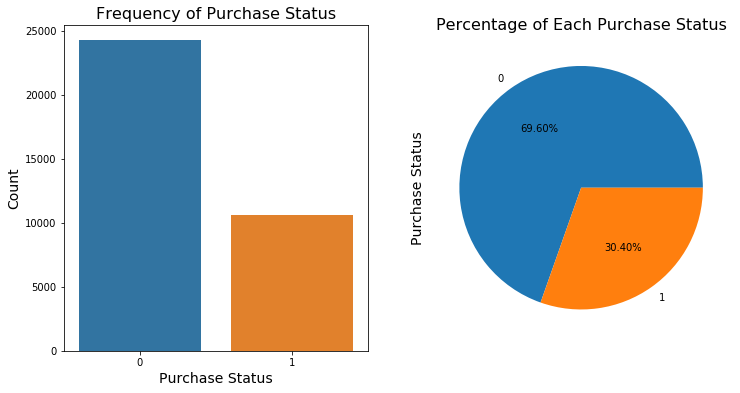

In [10]:
fig, axs = plt.subplots(1, 2, figsize = (12, 6))
sns.countplot(x = "is_purchase", data = train, ax = axs[0])
axs[0].set_title("Frequency of Purchase Status", size = 16)
axs[0].set_xlabel("Purchase Status", size = 14)
axs[0].set_ylabel("Count", size = 14)

train["is_purchase"].value_counts().plot(x = None, y = None, kind = "pie", ax = axs[1], autopct = "%1.2f%%") # "bar"
axs[1].set_title("Percentage of Each Purchase Status", size = 16)
#axs[1].set_xlabel("Loan", color = "white")
axs[1].set_ylabel("Purchase Status", size = 14)
plt.show()

The responsive feature **is_purchase** is composed of two classes: 0 (No) & 1 (Yes). 

**Suggestion:**
The dataset is imbalanced, the accuracy may not be a good model evaluator. The confusion Matrix should be used.

### 3.2 One example of the feature

The relationship between other features with the responsive variable **is_purchase** could also be checked with the same method.

### 1). total_search_times: 
Data Dictionary: "The total number of searches all the time."

In [0]:
train.groupby('is_purchase')['total_search_times'].describe()

,count,mean,std,min,25%,50%,75%,max
is_purchase,,,,,,,,
0,24254.0,10.804280,24.278222,1.0,2.0,4.0,11.0,804.0
1,10596.0,28.212722,81.905864,2.0,2.0,4.0,19.0,1968.0


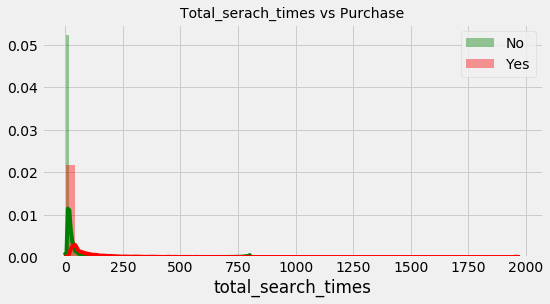

In [0]:
plt.figure(figsize = (8, 4))
df_temp_0 = train["total_search_times"][train.is_purchase == 0]
df_temp_1 = train["total_search_times"][train.is_purchase == 1]
sns.distplot(df_temp_0.dropna(), color = 'g')
sns.distplot(df_temp_1.dropna(), color = 'r')
plt.title("Total_serach_times vs Purchase", size = 14)
plt.legend(['No', 'Yes'])
plt.show()

The purchase  = 1 (Yes) tend to have higher  total_search_times.

## 4. Training, validation, testing datasets split

### 4.1. About data leakage

Two things about data leakage

1). The inappropriate features after the determination of the **responsive feature** would lead to data leakage.

2). The inappropriate split of training, validation, testing datasets would also need to data leakage, e.g., fill the missing values with mean, the calculation of the features based on the whole dataset before the data split. 

To avoid data leakage, it's better to split the datasets before data preprocessing. 

In [11]:
from sklearn.model_selection import train_test_split

# split the data
x_col_train = train.columns.tolist()

# remove target variables and other variables not be considered for this project from x
features_to_remove = ['user_id', 'is_purchase', 'purchase_times', 'first_activity_date', 'last_activity_date']
for feature in features_to_remove:
  x_col_train.remove(feature)
X = train[x_col_train]
y = train['is_purchase']

# 80% training data, 20% validation data
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 0)

df_train = pd.concat([x_train, y_train], axis = 1)
df_val = pd.concat([x_val, y_val], axis = 1)

# remove variables from test dataset, to make the test dataset consistent with the training dataset
x_col_test = test.columns.tolist()
features_to_remove = ['first_activity_date', 'last_activity_date']
for feature in features_to_remove:
  x_col_test.remove(feature)
df_test = test[x_col_test]
print("The shape of training dataset: {}".format(df_train.shape))
print("The shape of validation dataset: {}".format(df_val.shape))
print("The shape of test dataset: {}".format(df_test.shape))


The shape of training dataset: (27880, 18)
The shape of validation dataset: (6970, 18)
The shape of test dataset: (13643, 18)


## 5. Data normalization

In [13]:
from sklearn.preprocessing import StandardScaler

col = df_train.columns[0:-1]
scaler = StandardScaler()
df_train[col] = scaler.fit_transform(df_train[col])
df_val[col] = scaler.fit_transform(df_val[col])
df_test[col] = scaler.fit_transform(df_test[col])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


# 6. Model  building

- Logistic Regression

-  Random Forest

- XGBoosting

### 6.1 Model 1: Logistic Regression

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
lr = LogisticRegression()
lr.fit(df_train.drop("is_purchase", axis = 1), df_train["is_purchase"])

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

### 1). Model Evaluation: Accuracy

In [15]:
score = lr.score(df_val.drop("is_purchase", axis = 1), df_val["is_purchase"])
print("The accuracy: {:.5}".format(score))

The accuracy: 0.92941


### 2). Model Evaluation: Confusion Matrix, ROC_ACU_Score 

In [16]:
df_train["is_purchase"].value_counts()/len(df_train)

0    0.694871
1    0.305129
Name: is_purchase, dtype: float64

Since the data is imbalanced, 69% and 30%, the accuracy is not a good model evaluator. Next, I will consider the confusion matrix, and the roc to evaluate the model performance.

In [17]:
y_pred = lr.predict(df_val.drop("is_purchase", axis = 1))
confusion_matrix(df_val["is_purchase"], y_pred)

array([[4561,  320],
       [ 172, 1917]])

In [18]:
from sklearn.metrics import classification_report
print(classification_report(df_val["is_purchase"], y_pred))

              precision    recall  f1-score   support

           0       0.96      0.93      0.95      4881
           1       0.86      0.92      0.89      2089

    accuracy                           0.93      6970
   macro avg       0.91      0.93      0.92      6970
weighted avg       0.93      0.93      0.93      6970



In [19]:
from sklearn.metrics import roc_auc_score, roc_curve
lr_auc = roc_auc_score(lr.predict(df_val.drop("is_purchase", axis = 1)), df_val["is_purchase"])
print("The AUC: {:.5f}".format(lr_auc))

The AUC: 0.91031


### 6.2 Model 2: Random Forest

The Random Forest is a bagging method based on decisin tree.

### 1). Model Evaluation: Accuracy

In [21]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators = 50)
rfc.fit(df_train.drop("is_purchase", axis = 1), df_train["is_purchase"])
score = rfc.score(df_val.drop("is_purchase", axis = 1), df_val["is_purchase"])
print("The acc: {:.5f}".format(score))

The acc: 0.95538


### 2). Model Evaluation: ROC_AUC_Score

In [22]:
rf_auc = roc_auc_score(rfc.predict(df_val.drop("is_purchase", axis = 1)), df_val["is_purchase"])
print("The AUC: {:.5f}".format(rf_auc))

The AUC: 0.93863


### 3). Use GridSearchCV to determine the best parameters for the Random Forest, e.g., n_estimators

In [0]:
from sklearn.model_selection import GridSearchCV
rf = RandomForestClassifier()
parameters = {"n_estimators": [5, 10, 20, 35, 50, 100]}

gs = GridSearchCV(estimator = rf, param_grid = parameters, scoring = "roc_auc", cv = 5, n_jobs = -1)

grid_result = gs.fit(df_train.drop("is_purchase", axis = 1).values, df_train.is_purchase.values)

In [24]:
print("The best AUC: {:.5f}".format(grid_result.best_score_))

The best AUC: 0.99621


In [25]:
grid_result.best_params_

{'n_estimators': 100}

In [26]:
rfc = RandomForestClassifier(n_estimators = 100)
rfc.fit(df_train.drop("is_purchase", axis = 1), df_train["is_purchase"])
score = rfc.score(df_val.drop("is_purchase", axis = 1), df_val["is_purchase"])
score

0.9492109038737446

From the results above, the accuray is 94.921%, and the best roc_auc is 99.621 %when n_estimators = 100.

### 4). Features importance

In [28]:
column_names = df_train.drop("is_purchase", axis = 1).columns
column_names

Index(['total_search_times', 'unique_days', 'EmailOpen_times',
       'WebVisit_times', 'PageView_times', 'EmailClick_times',
       'FormSubmit_times', 'First_EmailOpen', 'First_ForSubmit',
       'First_EmailClickhrough', 'First_PageView', 'First_WebVisit',
       'Last_EmailOpen', 'Last_ForSubmit', 'Last_EmailClickhrough',
       'Last_PageView', 'Last_WebVisit'],
      dtype='object')

In [29]:
feature_importances = pd.DataFrame(rfc.feature_importances_,
                                   index = column_names,
                                    columns=['importance']).sort_values('importance', ascending=False)

feature_importances

,importance
EmailOpen_times,0.196198
First_EmailOpen,0.189452
Last_EmailOpen,0.186845
unique_days,0.139118
total_search_times,0.101304
FormSubmit_times,0.075765
EmailClick_times,0.054774
PageView_times,0.018473
WebVisit_times,0.016428
Last_WebVisit,0.008478


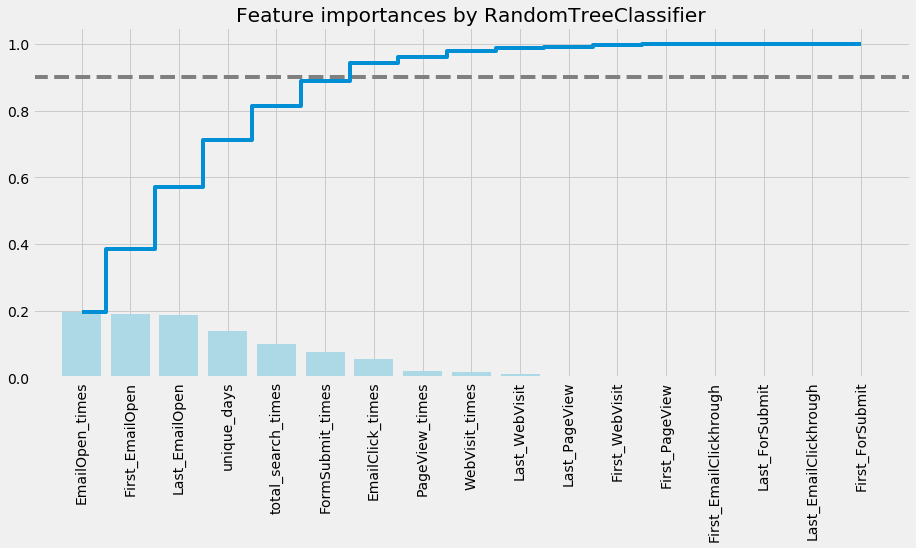

In [31]:
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (10,6)

## feature importances Visualization
importances = rfc.feature_importances_
feat_names = column_names
indices = np.argsort(importances)[::-1]
fig = plt.figure(figsize=(14,6))
plt.axhline(y = 0.9, linestyle = "--", color = "gray")
plt.title("Feature importances by RandomTreeClassifier")
plt.bar(range(len(indices)), importances[indices], color='lightblue',  align="center")
plt.step(range(len(indices)), np.cumsum(importances[indices]), where='mid', label='Cumulative')
plt.xticks(range(len(indices)), feat_names[indices], rotation= "vertical", fontsize=14) # 'vertical'
plt.xlim([-1, len(indices)])
plt.show()

### 6.3 Model 3: XGBoosting

The XGBoost is a boosting method.

### 1). Model Evaluation: Accuracy

In [32]:
from xgboost import XGBClassifier
xgc = XGBClassifier()
xgc.fit(df_train.drop("is_purchase", axis = 1), df_train["is_purchase"])
score = xgc.score(df_val.drop("is_purchase", axis = 1), df_val["is_purchase"])
print("The acc: {:.5f}".format(score))

The acc: 0.94146


### 12). Model Evaluation: AUC_ROC_Score

In [33]:
auc_xgc = roc_auc_score(xgc.predict(df_val.drop("is_purchase", axis = 1)), df_val["is_purchase"])
print("The AUC: {:.5f}".format(auc_xgc))

The AUC: 0.93447


# 7. Comparisons of the 3 models: **LR**, **RF**, **XGBoost**

In [34]:
models = ["Logistic Regression", "Random Forest", "XGBoost"]
acc = [0.92941, 0.95093, 0.94146]
auc = [0.91031, 0.99609, 0.93447]

res = pd.DataFrame({"Models": models, "Accuracy": acc, "AUC": auc})
res

,Models,Accuracy,AUC
0,Logistic Regression,0.92941,0.91031
1,Random Forest,0.95093,0.99609
2,XGBoost,0.94146,0.93447


From the discussion above, the accuracy for the 3 models are very similar. Since the data is imbalanced, the accuracy is not a indicator. 

The Aera Under Curve (AUR_ROC) is a good indicator of the model. Based on the AUC, the Random Forest Model performances best.
 

# 8. Test dataset prediction from the best model: **Random Forest**
From the discussion above, after a through data preprocessing and data engineering, 3 models (LR, RF, XGBoosting) are created and evaluated. Based on the the accuracy, and AUC_ROC indicaters, the Random Forest model performances best.

Thus, I will use the Random Forest model to predict the user_purchase. And the top 1000 user_id most likely to make a purchase are listed and saved to a csv file. 

In [35]:
df_test.head()

,user_id,total_search_times,unique_days,EmailOpen_times,WebVisit_times,PageView_times,EmailClick_times,FormSubmit_times,First_EmailOpen,First_ForSubmit,First_EmailClickhrough,First_PageView,First_WebVisit,Last_EmailOpen,Last_ForSubmit,Last_EmailClickhrough,Last_PageView,Last_WebVisit
0,0000ecf58c94668,-0.114198,0.052713,0.112233,-0.238538,-0.237251,-0.259552,-0.22221,0.237593,0.0,0.0,-0.379435,-0.388109,0.242545,0.0,0.0,-0.372706,-0.380572
1,000132f21724ee2,-0.357927,-0.567120,-0.574250,-0.238538,-0.237251,0.466226,-0.22221,0.237593,0.0,0.0,-0.379435,-0.388109,0.242545,0.0,0.0,-0.372706,-0.380572
2,0001b315b991cf0,-0.276684,-0.257204,-0.231008,-0.238538,-0.237251,-0.259552,-0.22221,0.237593,0.0,0.0,-0.379435,-0.388109,0.242545,0.0,0.0,-0.372706,-0.380572
3,000269150971d08,-0.195441,-0.102245,-0.059387,-0.238538,-0.237251,-0.259552,-0.22221,0.237593,0.0,0.0,-0.379435,-0.388109,0.242545,0.0,0.0,-0.372706,-0.380572
4,000297ba4fa5026,-0.276684,-0.257204,-0.231008,-0.238538,-0.237251,-0.259552,-0.22221,0.237593,0.0,0.0,-0.379435,-0.388109,0.242545,0.0,0.0,-0.372706,-0.380572


In [0]:
y_pred = rfc.predict_proba(df_test.drop("user_id", axis = 1))
y_pred = y_pred[:,1]


In [37]:
y_predicted = pd.DataFrame(y_pred, columns = ['predicted'])
y_predicted.tail()

,predicted
13638,0.27
13639,0.06
13640,0.06
13641,0.06
13642,0.77


In [39]:
df_test = pd.concat([df_test, y_predicted], axis = 1)
df_test.head()

,user_id,total_search_times,unique_days,EmailOpen_times,WebVisit_times,PageView_times,EmailClick_times,FormSubmit_times,First_EmailOpen,First_ForSubmit,First_EmailClickhrough,First_PageView,First_WebVisit,Last_EmailOpen,Last_ForSubmit,Last_EmailClickhrough,Last_PageView,Last_WebVisit,predicted
0,0000ecf58c94668,-0.114198,0.052713,0.112233,-0.238538,-0.237251,-0.259552,-0.22221,0.237593,0.0,0.0,-0.379435,-0.388109,0.242545,0.0,0.0,-0.372706,-0.380572,0.40
1,000132f21724ee2,-0.357927,-0.567120,-0.574250,-0.238538,-0.237251,0.466226,-0.22221,0.237593,0.0,0.0,-0.379435,-0.388109,0.242545,0.0,0.0,-0.372706,-0.380572,0.00
2,0001b315b991cf0,-0.276684,-0.257204,-0.231008,-0.238538,-0.237251,-0.259552,-0.22221,0.237593,0.0,0.0,-0.379435,-0.388109,0.242545,0.0,0.0,-0.372706,-0.380572,0.00
3,000269150971d08,-0.195441,-0.102245,-0.059387,-0.238538,-0.237251,-0.259552,-0.22221,0.237593,0.0,0.0,-0.379435,-0.388109,0.242545,0.0,0.0,-0.372706,-0.380572,0.18
4,000297ba4fa5026,-0.276684,-0.257204,-0.231008,-0.238538,-0.237251,-0.259552,-0.22221,0.237593,0.0,0.0,-0.379435,-0.388109,0.242545,0.0,0.0,-0.372706,-0.380572,0.00


In [0]:
df_test = df_test.sort_values(by='predicted', ascending=False)

In [42]:
top_1000_potential_users = df_test[["user_id", "predicted"]].head(10)
top_1000_potential_users

,user_id,predicted
2935,049ee528b018f28,1.00
10235,10205dd0c759b28,1.00
7934,0c8076de3d29427,0.99
13217,15073749cb087bf,0.99
8475,0d616bfb2f9660c,0.99
11503,1234c44f4154e41,0.99
11337,11f5977c523731c,0.99
8638,0da5f7675d623ff,0.98
6702,0a814e3e0b85608,0.98
6097,098804b2b3841ba,0.98


### Save the top 1000 potential users and submit the result

In [0]:
top_1000_potential_users.to_csv('Top_1000_potential_users.csv')